In [1]:
import time

from pythonbpf import *
from pylibbpf import *

from ctypes import c_void_p, c_int64, c_uint64, c_int32
import matplotlib.pyplot as plt

In [2]:
@bpf
@map
def hist() -> HashMap:
    return HashMap(key=c_int32, value=c_uint64, max_entries=4096)

@bpf
@section("tracepoint/syscalls/sys_enter_clone")
def hello(ctx: c_void_p) -> c_int64:
    process_id = pid()
    one = 1
    prev = hist().lookup(process_id)
    if prev:
        previous_value = prev + 1
        print(f"count: {previous_value} with {process_id}")
        hist().update(process_id, previous_value)
        return c_int64(0)
    else:
        hist().update(process_id, one)
    return c_int64(0)


@bpf
@bpfglobal
def LICENSE() -> str:
    return "GPL"

b = BPF()

Module(
    body=[
        FunctionDef(
            name='hist',
            args=arguments(
                posonlyargs=[],
                args=[],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                Return(
                    value=Call(
                        func=Name(id='HashMap', ctx=Load()),
                        args=[],
                        keywords=[
                            keyword(
                                arg='key',
                                value=Name(id='c_int32', ctx=Load())),
                            keyword(
                                arg='value',
                                value=Name(id='c_uint64', ctx=Load())),
                            keyword(
                                arg='max_entries',
                                value=Constant(value=4096))]))],
            decorator_list=[
                Name(id='bpf', ctx=Load()),
                Name(i

Recording
PID 116823 called clone() >40 times
PID 117099 called clone() >40 times
PID 116696 called clone() >40 times
Total PIDs with clone() >40 times: 3


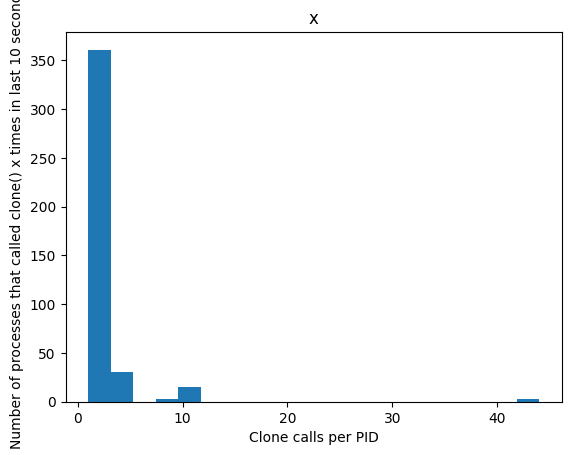

In [3]:
b.load_and_attach()
hist = BpfMap(b, hist)
print("Recording")
time.sleep(10)

counts = list(hist.values())
x = 0
for key in hist.keys():
    if hist[key] > 40:
        x += 1
        print(f"PID {key} called clone() >40 times")
print(f"Total PIDs with clone() >40 times: {x}")
plt.hist(counts, bins=20)
plt.xlabel("Clone calls per PID")
plt.ylabel("Number of processes that called clone() x times in last 10 seconds")
plt.title("x")
plt.show()